* The clips can contain background music --> this could be a way of matching using a pretrained  music detection model
* The training data provides gender and age; could train a gender seperation model, or use a pretrained one as a starting point for accepting/rejecting
* The volume might be a way of pairing


In [1]:
# https://github.com/pyannote/pyannote-audio/tree/develop/tutorials/data_preparation
# https://github.com/pyannote/pyannote-audio/tree/develop/tutorials/pretrained/model
# http://pyannote.github.io/pyannote-core/
# https://github.com/pyannote/pyannote-audio/tree/develop/tutorials/pretrained/model
# Needed pip install numba==0.48 and librosa==0.7.2

## https://github.com/pyannote/pyannote-audio/tree/develop/tutorials/models/speaker_embedding
# https://github.com/pyannote/pyannote-pipeline/blob/18e2c609d1fef4f01d1589231c5a1855fbb3ae5b/pyannote/pipeline/blocks/classification.py#L91
# https://github.com/pyannote/pyannote-audio/tree/develop/tutorials/finetune
# https://github.com/pyannote/pyannote-audio-hub#speaker-embedding

In [12]:
import torch
from pathlib import Path
import numpy as np
from tqdm import tqdm
# speaker embedding model trained on AMI training set
#emb = torch.hub.load('pyannote/pyannote-audio', 'emb_ami')
emb = torch.hub.load('pyannote/pyannote-audio', 'emb_voxceleb')

Using cache found in /home/ben/.cache/torch/hub/pyannote_pyannote-audio_master


In [4]:
emb

In [13]:
# one can use their own file like this...

test_file1 = {'uri': 'filename', 'audio': '/media/ben/datadrive/Zalo/voice-verification/Train-Test-Data/dataset/5-F-27/5-2.wav'}
test_file2 = {'uri': 'filename', 'audio': '/media/ben/datadrive/Zalo/voice-verification/Train-Test-Data/dataset/5-F-27/5.wav'}
test_file3 = {'uri': 'filename', 'audio': '/media/ben/datadrive/Zalo/voice-verification/Train-Test-Data/dataset/812-M-27/812.wav'}
test = [test_file1, test_file2]
amifile = {'uri': 'filename', 'audio': '/media/ben/datadrive/Software/pyannote-audio/data/ami/amicorpus/ES2003c/audio/ES2003c.Mix-Headset.wav'}
embeddings = emb(test_file1)
embeddings.data.shape

(1, 512)

In [14]:
embeddings.data.shape

(1, 512)

In [6]:

chunks = embeddings.sliding_window
print(f'Embeddings were extracted every {1000 * chunks.step:g}ms on {1000 * chunks.duration:g}ms-long windows.')


Embeddings were extracted every 500ms on 2000ms-long windows.


In [15]:
 torch.cuda.current_device(), torch.cuda.is_available()

(0, True)

In [37]:

speaker_ids = []
uris = []
embeddings = []
root = Path("/media/ben/datadrive/Zalo/voice-verification/Train-Test-Data/dataset/")
j = 0
for i in tqdm(root.glob("./*/*.wav")):
    speaker_id = str(i.parents[0].name)
    uri = str(speaker_id) + "_" + str(i.stem)
    embedding = np.mean(emb({"uri": uri, "audio": str(i)}), axis=0, keepdims=True)[0]
    speaker_ids.append(speaker_id)
    uris.append(uri)
    embeddings.append(embedding)
    
X = np.array(embeddings)
_, y_true = np.unique(speaker_ids, return_inverse=True)



10556it [19:56,  8.82it/s]


In [36]:
X.shape

(101, 512)

In [39]:
with open('embeddings_voxceleb.npy', 'wb') as f:
    np.save(f, X)
#with open('speaker_ids.npy', 'wb') as f:
#    np.save(f, speaker_ids)
#with open('uris.npy', 'wb') as f:
#    np.save(f, uris)

    
#X = np.load('embeddings.npy')
#speaker_ids = np.load("speaker_ids.npy")
#_, y_true = np.unique(speaker_ids, return_inverse=True)
#distance = cdist(np.mean(emb1, axis=0, keepdims=True), 
#                 np.mean(emb2, axis=0, keepdims=True), 
#                 metric='cosine')[0, 0]

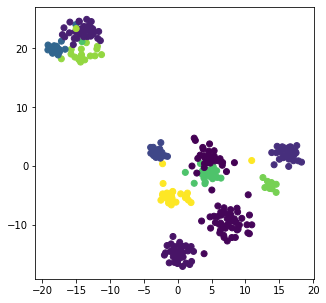

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
# apply tSNE on embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric="cosine")
X_2d = tsne.fit_transform(X[0:300])


# plot 
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
plt.scatter(*X_2d.T, c=y_true[0:300])

In [41]:
from pyannote.core.utils.distance import l2_normalize
from pyannote.core.utils.distance import cdist

In [43]:
X_target_norm = l2_normalize(X[0:1])
X_norm = l2_normalize(X)
distance = cdist(X_target_norm, X_norm, metric="cosine")
targets = np.argmin(distance, axis=0)
threshold = 0.1
#for i, k in enumerate(targets):
#    if distance[k, i] > self.threshold:
for i, k in enumerate(targets):
    # if distance[k, i] > threshold:
    print(f"k:{k} to {i}: distance: {distance[k, i]} label {y_true[i]} { {y_true[i] == y_true[k]}}")

k:0 to 0: distance: 0.0 label 307 {True}
k:0 to 1: distance: 0.43236030968498673 label 307 {True}
k:0 to 2: distance: 0.7071949495730905 label 307 {True}
k:0 to 3: distance: 0.3652063239927975 label 307 {True}
k:0 to 4: distance: 0.6572100342273961 label 307 {True}
k:0 to 5: distance: 0.6179489163144882 label 307 {True}
k:0 to 6: distance: 0.4013982039564019 label 307 {True}
k:0 to 7: distance: 0.5456975054002258 label 307 {True}
k:0 to 8: distance: 0.5425264044432987 label 307 {True}
k:0 to 9: distance: 0.5324121591137672 label 307 {True}
k:0 to 10: distance: 0.44476628515536365 label 307 {True}
k:0 to 11: distance: 0.7036470296796915 label 307 {True}
k:0 to 12: distance: 0.4084543646482719 label 307 {True}
k:0 to 13: distance: 0.3504154500600284 label 307 {True}
k:0 to 14: distance: 0.4574390359009418 label 307 {True}
k:0 to 15: distance: 0.722514855356003 label 307 {True}
k:0 to 16: distance: 0.42970964557885727 label 307 {True}
k:0 to 17: distance: 0.8392509498098941 label 264 {Fal

k:0 to 2828: distance: 0.6017622396223268 label 136 {False}
k:0 to 2829: distance: 0.8101910162706776 label 136 {False}
k:0 to 2830: distance: 0.6817998877684248 label 136 {False}
k:0 to 2831: distance: 0.6001911876101198 label 136 {False}
k:0 to 2832: distance: 0.5530872416922381 label 136 {False}
k:0 to 2833: distance: 0.5312782637938225 label 136 {False}
k:0 to 2834: distance: 0.5423607612719223 label 136 {False}
k:0 to 2835: distance: 0.525999112148553 label 136 {False}
k:0 to 2836: distance: 0.6997840085635466 label 136 {False}
k:0 to 2837: distance: 0.5314806492139943 label 136 {False}
k:0 to 2838: distance: 0.6665596428772549 label 136 {False}
k:0 to 2839: distance: 0.6314993937986041 label 136 {False}
k:0 to 2840: distance: 0.7108754023111448 label 136 {False}
k:0 to 2841: distance: 0.6231481611285852 label 136 {False}
k:0 to 2842: distance: 0.6583741804328316 label 136 {False}
k:0 to 2843: distance: 0.5218472103905941 label 136 {False}
k:0 to 2844: distance: 0.5421155638578674

k:0 to 5257: distance: 0.5620254470193173 label 97 {False}
k:0 to 5258: distance: 0.7080917541808389 label 97 {False}
k:0 to 5259: distance: 0.5517054325907311 label 97 {False}
k:0 to 5260: distance: 0.5256306122669319 label 97 {False}
k:0 to 5261: distance: 0.6021586792485246 label 97 {False}
k:0 to 5262: distance: 0.4387475911639068 label 97 {False}
k:0 to 5263: distance: 0.6757132005480488 label 97 {False}
k:0 to 5264: distance: 0.5432922663505086 label 97 {False}
k:0 to 5265: distance: 0.4576496296181316 label 97 {False}
k:0 to 5266: distance: 0.43047142682865824 label 97 {False}
k:0 to 5267: distance: 0.633062287548902 label 97 {False}
k:0 to 5268: distance: 0.5515655006244962 label 97 {False}
k:0 to 5269: distance: 0.4303002223439685 label 97 {False}
k:0 to 5270: distance: 0.5873060813641793 label 97 {False}
k:0 to 5271: distance: 0.3752442091188658 label 97 {False}
k:0 to 5272: distance: 0.4117292280774777 label 376 {False}
k:0 to 5273: distance: 0.4983857078465038 label 376 {Fa

k:0 to 7941: distance: 0.9348478848550255 label 53 {False}
k:0 to 7942: distance: 0.8942332126488768 label 53 {False}
k:0 to 7943: distance: 0.8405193348888186 label 53 {False}
k:0 to 7944: distance: 0.8612286468517838 label 53 {False}
k:0 to 7945: distance: 0.8279428314102351 label 53 {False}
k:0 to 7946: distance: 0.8624657138545455 label 53 {False}
k:0 to 7947: distance: 0.7473466531779551 label 53 {False}
k:0 to 7948: distance: 0.9246007533170059 label 53 {False}
k:0 to 7949: distance: 0.9006639008778461 label 53 {False}
k:0 to 7950: distance: 0.9150982960903353 label 53 {False}
k:0 to 7951: distance: 0.8573118818868324 label 53 {False}
k:0 to 7952: distance: 0.7926348103387533 label 53 {False}
k:0 to 7953: distance: 0.8831880199201987 label 53 {False}
k:0 to 7954: distance: 0.7661903403587087 label 53 {False}
k:0 to 7955: distance: 0.8061265917429692 label 53 {False}
k:0 to 7956: distance: 0.8795809454047525 label 53 {False}
k:0 to 7957: distance: 0.8747644257594551 label 53 {Fals

In [45]:
X.shape

(10556, 512)

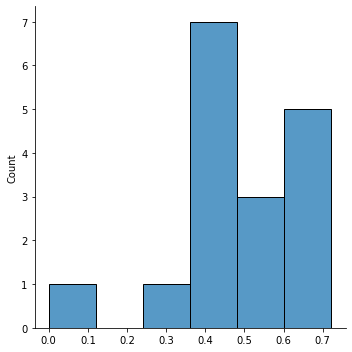

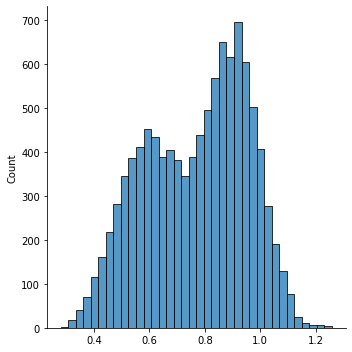

In [46]:
import seaborn as sns
# Taking the first item,  X[0:1]
target_index = 0
pred = distance[0,:]
Y = y_true == y_true[0] 

not_matching = pred[~Y]
matching = pred[Y]



sns.displot(matching)
sns.displot(not_matching)

In [99]:
# train a linear classifier to decide on the threshold

(1, 10626)

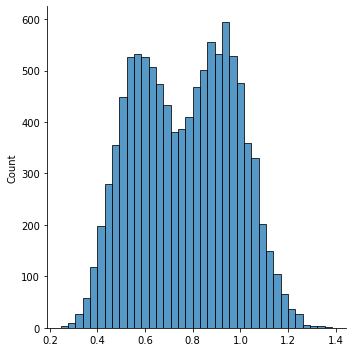